In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
from scipy import optimize, interpolate
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from scipy.optimize import basinhopping
import warnings
import pickle

In [2]:
# /data/df.pickleの読み込み
df = pd.read_pickle('../data/df.pickle')

df = df.dropna()

# データの分割
df_p1 = df[(df['started_at'] >= '2020-03-01') & (df['started_at'] < '2020-06-01')].dropna()
df_p2 = df[(df['started_at'] >= '2020-06-01') & (df['started_at'] < '2020-11-01')].dropna()
df_p3 = df[(df['started_at'] >= '2020-12-01') & (df['started_at'] < '2021-03-01')].dropna()
df_p4 = df[(df['started_at'] >= '2021-03-01') & (df['started_at'] < '2023-10-01')].dropna()
df_p4_1 = df[(df['started_at'] >= '2021-03-01') & (df['started_at'] < '2022-01-01')].dropna()
df_p4_2 = df[(df['started_at'] >= '2022-01-01') & (df['started_at'] < '2023-10-01')].dropna()
df_left = pd.concat([df_p1, df_p2, df_p3, df_p4_1], axis=0)
df_right = pd.concat([df_p4_2], axis=0)



In [3]:
def return_nm(df):
    df['started_at'] = pd.to_datetime(df['started_at'])
    df['ended_at'] = pd.to_datetime(df['ended_at'])
    # started_atで昇順にソート
    df = df.sort_values(by='started_at')
    current_timestamp = df['started_at'].min()
    end_timestamp = df["started_at"].max()
    interval = timedelta(days=1)

    node_list = []
    edge_list = []
    timestamp = []

    while current_timestamp <= end_timestamp:
        timestamp.append(current_timestamp)
        next_timestamp = current_timestamp + interval
        df_tmp = df[(df['started_at'] >= current_timestamp) & (df['started_at'] < next_timestamp)]

        # node_listにはユニークなstart_station_idを追加
        node_list.append(len(df_tmp['start_station_id'].unique()))

        # edge_listにはdf_tmpの行数を追加
        edge_list.append(len(df_tmp))

        current_timestamp = next_timestamp

    # node_listとedge_listで0の値を削除
    node_list = np.array(node_list)
    edge_list = np.array(edge_list)
    timestamp = np.array(timestamp)
    active_node_list = node_list[node_list != 0]
    edge_list = edge_list[edge_list != 0]
    timestamp = timestamp[:len(node_list)]

    return active_node_list, edge_list, timestamp

In [4]:
node_left, edge_left, timestamp_left = return_nm(df_left)

In [5]:
# node_leftとedge_leftを組みにしてdf_leftを作成
left = pd.DataFrame({'node': node_left, 'edge': edge_left})
# df_leftのnodeを昇順にして並び替え
left = left.sort_values(by='node')
# インデックスを振り直す
left = left.reset_index(drop=True)
left.head()

,node,edge
0,106,190
1,136,221
2,173,312
3,215,368
4,217,494


In [107]:
left

,node,edge,node_norm,edge_norm
0,136,221,32,32
1,173,312,69,123
2,215,368,111,179
3,217,494,113,305
4,222,663,118,474
...,...,...,...,...
602,609,32694,505,32505
603,609,20769,505,20580
604,610,27349,506,27160
605,613,21726,509,21537


In [6]:
# 正規化する
left["node_norm"] = left["node"] - left["node"].min() + 2
left["edge_norm"] = left["edge"] - left["edge"].min() + 1

# 一番最初の行を削除
left = left.drop(0)

# インデックスを振り直す
left = left.reset_index(drop=True)


In [108]:
M = left["edge"] #left["edge_norm"]
N = left["node"] #left["node_norm"]

In [ ]:
M = left["edge"] #left["edge_norm"]
N = left["node"] #left["node_norm"]

In [ ]:
M = left["edge"] #left["edge_norm"]
N = left["node"] #left["node_norm"]

In [117]:
def Model1(M,kappa):
    def Np(kappa):
        return (1+np.sqrt(1+32*M/kappa))/2
    N = Np(kappa)*(1-2/kappa/Np(kappa)*(1 - (1-kappa/2)**Np(kappa)))
    return N


def Model2(M,Np):
    def kappa(Np):
        return 8*M/Np/(Np-1)
    N = Np*(1 - 2/kappa(Np)/Np*(1 - (1-kappa(Np)/2)**Np))
    return N



In [121]:
kappa_hat, _ = np.count = optimize.curve_fit(Model1, M, N)

c:\Users\Yoshitaka\anaconda3\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Yoshitaka\anaconda3\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Yoshitaka\anaconda3\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


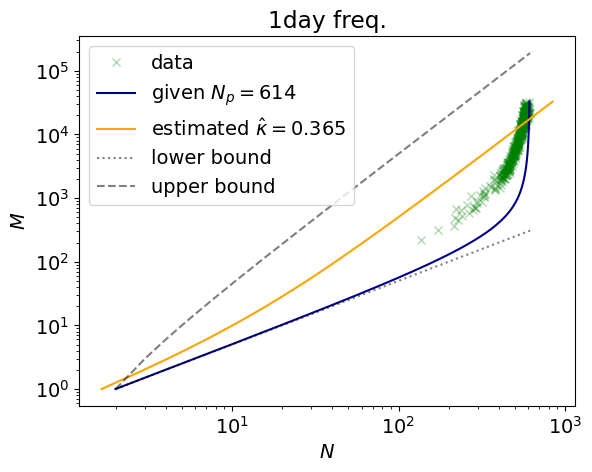

In [143]:
plt.rcParams["font.size"]=14
Np = 614
x = np.arange(2,np.max(N))
y = np.arange(1,np.max(M))

plt.plot(N, M, "x", c="green", alpha=0.3, label = "data")
plt.plot(Model2(y,Np), y, "-", c="darkblue", label = r"given $N_p=614$")
plt.plot(Model1(y,kappa_hat), y, "-", c="orange", label = r"estimated $\hat{\kappa} = 0.365$")
plt.plot(x,x/2, label="lower bound", c = "black", alpha= 0.5, ls = ":")
plt.plot(x,x*(x-1)/2, label="upper bound", c = "black", alpha = 0.5, ls = "--")
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$N$")
plt.ylabel(r"$M$")
plt.title("1day freq.")
plt.legend()